# Check distribution of likelihood ratio against Wilk's theorem

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2

## Data

In [2]:
filenames = ["carl", "carl"]
labels = ["CARL (raw)", "CARL (cal)"]
calibrated = [False, True]
nmethods = len(filenames)


In [124]:
llrs = []

for filename, cal in zip(filenames, calibrated):
    if cal:
         llrs.append(np.load("../data/results/llr_calibrated_{}_grid.npy".format(filename))
    else:
         llrs.append(np.load("../data/results/llr_{}_grid.npy".format(filename))

llrs = np.array(llrs)

## Calculate likelihood ratio wrt best fit

In [125]:
grid_res = 21

alpha_test = np.linspace(10., 400., grid_res)
beta_test = np.linspace(-1., -3., grid_res)

theta0, theta1 = np.meshgrid(alpha_test, beta_test)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

bin_size = alpha_test[1] - alpha_test[0]
alpha_edges = np.linspace(alpha_test[0] - bin_size/2, alpha_test[-1] + bin_size/2, grid_res + 1)
bin_size = beta_test[1] - beta_test[0]
beta_edges = np.linspace(beta_test[0] - bin_size/2, beta_test[-1] + bin_size/2, grid_res + 1)

In [126]:
idx_mle = np.argmax(llrs, axis=1)
theta_mle = theta_grid[idx_mle]

In [128]:
for i in range(nmethods):
    bincount = np.bincount(idx_mle[0])
    idx_mle_max = np.argmax(bincount)
    n_mle_max = np.max(bincount)
    print(labels[i], theta_grid[idx_mle_max], n_mle_max / len(idx_mle[0]))

CARL [10.  -1.5] 0.13935
CARL-aux [10.  -1.5] 0.13935
ALICE [10.  -1.5] 0.13935
ALICE-aux [10.  -1.5] 0.13935
ALICES [10.  -1.5] 0.13935
ALICES-aux [10.  -1.5] 0.13935


In [129]:
idx_true = 9*21+7
llr_true = llrs[:, idx_true]
llr_mle = np.max(llrs, axis=1)

In [130]:
q = -2. * (llr_true - llr_mle)

## Plot test statistic histo

In [131]:
qmin = 0.
qmax = 8.
qbins = 100


In [132]:
wilks = chi2.rvs(size=100000, df=2)

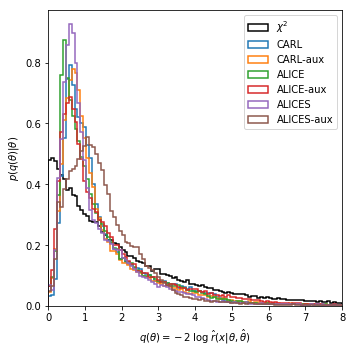

In [133]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()

plt.hist(
    wilks, range=(qmin, qmax), bins=qbins,
    histtype="step", density=True,
    lw=1.5, color="black",
    label=r"$\chi^2$"
)
for i in range(nmethods):
    plt.hist(
        q[i], range=(qmin, qmax), bins=qbins,
        histtype="step", density=True,
        lw=1.5, color="C{}".format(i),
        label=labels[i]
    )
    
plt.legend()
    
#ax.set_yscale("log")
plt.xlim(qmin, qmax)
#plt.ylim(1.e-3, 2.)

plt.xlabel(r"$q(\theta) = -2\; \log \; \hat{r}(x|\theta, \hat{\theta})$")
plt.ylabel(r"$p(q(\theta) | \theta)$")
    
plt.tight_layout()
plt.savefig("../figures/chi_squared.pdf")

## Plot MLE

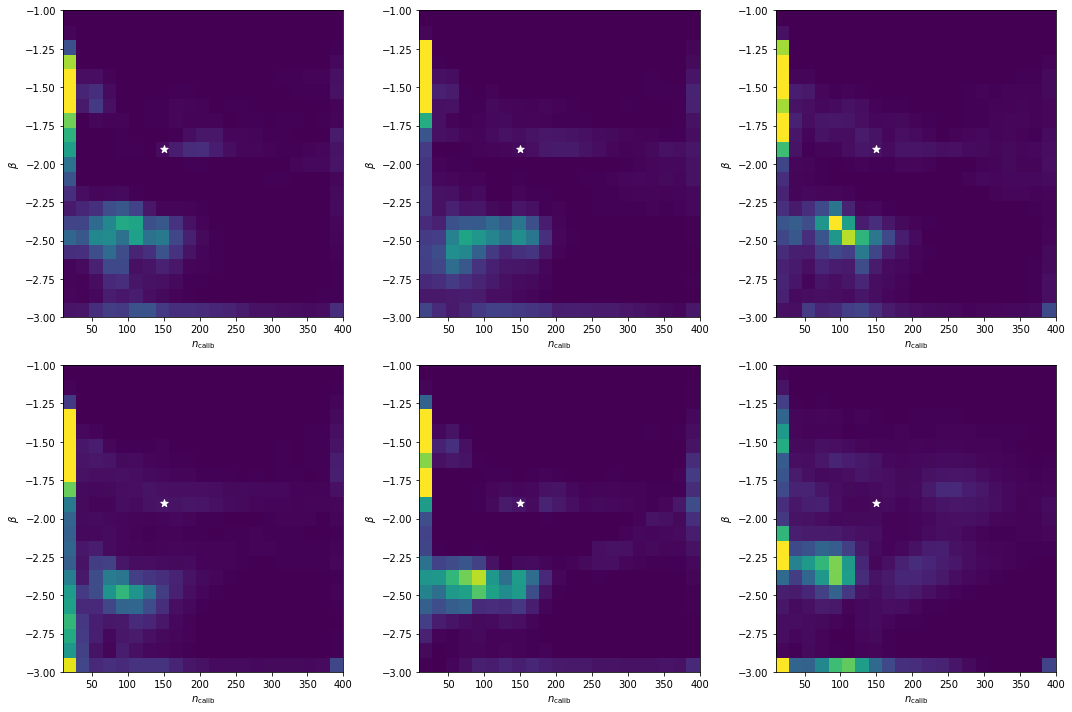

In [135]:
fig = plt.figure(figsize=(nmethods/2*5,10.))

for i in range(nmethods):
    ax = plt.subplot(2, nmethods // 2, i+1)
    
    cm = plt.hist2d(
        theta_mle[i,:,0], theta_mle[i,:,1],
        bins=[21, 21],
        range=[[10.,400.], [-3.,-1.]],
        normed=True,
        vmin=0., vmax=0.02,
        cmap="viridis"
    )
    plt.scatter(150., -1.9, s=60., color='white', marker='*')

    plt.xlabel(r'$n_{\mathrm{calib}}$')
    plt.ylabel(r'$\beta$')
    
plt.tight_layout()
plt.savefig("../figures/mle_distribution.pdf")